# 1. Preparação do notebook

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [2]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [3]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Mean Reverting] Geração de séries temporais.xlsx to [BM Mean Reverting] Geração de séries temporais.xlsx


,bm_mean_reverting_1,bm_mean_reverting_2,bm_mean_reverting_3,bm_mean_reverting_4,bm_mean_reverting_5,bm_mean_reverting_6,bm_mean_reverting_7,bm_mean_reverting_8,bm_mean_reverting_9,bm_mean_reverting_10
0,100.000000,100.000000,100.000000,100.000000,121.279132,100.000000,100.000000,100.000000,100.000000,100.000000
1,100.993428,100.002220,100.081046,98.892131,97.345432,124.141016,97.942328,98.034010,99.708042,102.288785
2,100.667228,96.913241,101.599342,113.918417,95.124120,94.305254,101.622130,119.114103,100.706185,102.224046
3,101.929244,98.053347,101.278089,102.161196,94.955115,93.823898,99.115929,119.230326,98.927860,102.144690
4,104.878841,99.817886,100.514413,101.731807,95.449351,91.270508,98.740509,99.216977,99.999928,103.228416


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [4]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [5]:
# Seleção da série
series = df['bm_mean_reverting_1'].values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [6]:
X

array([[100.        ],
       [100.99342831],
       [100.66722829],
       ...,
       [ 97.34511423],
       [101.94085634],
       [ 99.20205681]])

In [7]:
y

array([100.99342831, 100.66722829, 101.92924395, ..., 101.94085634,
        99.20205681, 100.78475756])

## 3.2. Normalização

In [8]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [9]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [10]:
# Função para treinar Random Forest com otimização de hiperparâmetros
def train_rf(X_train, y_train):
    param_grid = {
        'n_estimators': [10, 50, 100, 200],  # Número de árvores na floresta
        'max_features': ['auto', 'sqrt', 'log2'],  # Número de atributos para construir a árvore
        'min_samples_leaf': [1, 3, 5]  # Número mínimo de amostras por nó
    }

    model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    model.fit(X_train, y_train)
    return model.best_estimator_

In [11]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
rf_model = train_rf(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

## 3.3. Avaliação do modelo

In [12]:
# Previsões no conjunto de treino
y_train_pred_scaled = rf_model.predict(X_train).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = rf_model.predict(X_test).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [13]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values).round(2)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values).round(2)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 2.78%
sMAPE Teste: 3.72%


In [14]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 4.93
RMSE Teste: 6.33


In [15]:
# Cálculo do Huber Loss
def huber_loss(actual, predicted, delta=1.0):
    error = predicted - actual
    is_small_error = np.abs(error) <= delta
    squared_loss = 0.5 * error ** 2
    linear_loss = delta * (np.abs(error) - 0.5 * delta)
    return np.mean(np.where(is_small_error, squared_loss, linear_loss))

huber_loss_train = huber_loss(train_results['Actual'].values, train_results['Predicted'].values)
huber_loss_test = huber_loss(test_results['Actual'].values, test_results['Predicted'].values)

print(f'Huber Loss Treino: {huber_loss_train:.2f}')
print(f'Huber Loss Teste: {huber_loss_test:.2f}')

Huber Loss Treino: 2.33
Huber Loss Teste: 3.16


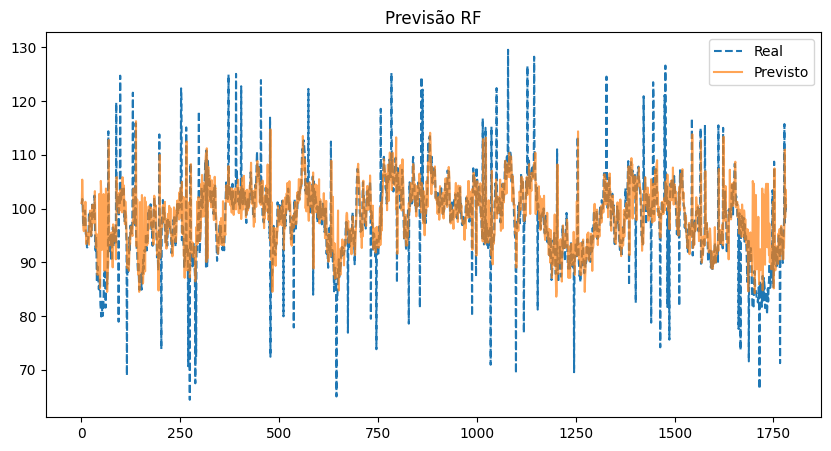

In [16]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
plt.title(f'Previsão RF')
plt.show()

# 4. Análise dos erros

In [17]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
46,66.512449,84.359970,-17.847521
50,68.533008,84.730951,-16.197944
80,75.442138,95.456766,-20.014628
88,119.792370,102.720891,17.071480
91,123.033651,105.091529,17.942123
...,...,...,...
1688,71.541041,94.573972,-23.032932
1715,66.424223,90.411478,-23.987255
1729,81.475541,89.535281,-8.059740
1734,80.296865,103.063911,-22.767046


In [18]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,100.993428,99.599557,1.393871,False
1,100.667228,101.921766,-1.254538,False
2,101.929244,100.891666,1.037578,False
3,104.878841,103.294147,1.584694,False
4,104.166593,102.794415,1.372178,False


In [19]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 631229.0
Valor-p: 0.11451969842771059
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [20]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 594.1500571472097
Valor-p: 9.59299855899016e-130
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [21]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: 0.01560574128200554
Valor-p: 0.22906190166142915
Não há evidência estatística de que os outliers impactam significativamente os erros.
